In [ ]:
# Importação de bibliotecas necessárias e configuração de caminhos
from google.colab import drive
drive.mount('/content/drive')

import os
import re
from time import sleep
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install jcamp -q
!pip install rdkit -q
from rdkit import Chem
from jcamp import jcamp_read

# Caminho para os espectros
SPECTRA_PATH = '../datasets/spectras/'
DATASET_PATH = '../datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def identify_functional_groups(inchi):
    try:
        mol = Chem.MolFromInchi(inchi)
        if mol is None:
            return None  # Handle cases where InChI cannot be converted to a molecule

        func_grp_structs = {func_name : Chem.MolFromSmarts(func_smarts) \
                            for func_name, func_smarts in func_grp_smarts.items()}

        results = {}
        for func_name, func_struct in func_grp_structs.items():
            matches = mol.GetSubstructMatches(func_struct)
            results[func_name] = len(matches) > 0
        return results
    except Exception as e:
        print(f"Erro ao processar InChI: {inchi}, Erro: {e}")
        return None

def JCAMP_reader(cas_number, spectra_path=SPECTRA_PATH):
    """Lê arquivos JCAMP (.jdx) usando encoding latin-1."""
    filename = os.path.join(spectra_path, f'{cas_number}-IR.jdx')
    with open(filename, 'r', encoding='latin-1') as filehandle:
        data = jcamp_read(filehandle)
    data['filename'] = filename
    return data

def scraping_data(df_cas, save_target = False, target_name = None):
  # nist_url = "https://webbook.nist.gov/cgi/cbook.cgi"

  if len(df_cas.CAS.values) == 0:
    return None

  inchi_list = []
  for i, cas in enumerate(df_cas.CAS.values):

      nist_url = f"https://webbook.nist.gov/cgi/cbook.cgi?ID={cas}&Units=SI&cIR=on#IR-Spec"
      response = requests.get(nist_url)

      try:
        inchi_list.append(response.text.split('''inChI" : "''')[1].split('"')[0])
      except:
        inchi_list.append(None)

      sleep(1)
      print(f'i:{i} ({(i+1)/len(df_cas.CAS.values) *100 :.2f}%) - {cas}: Processed')
  y_target = []
  for inchi in inchi_list:

    if inchi is not None:
      y_target.append(identify_functional_groups(inchi))
    else:
      y_target.append(None)


  df_cas['inchi'] = inchi_list
  df_cas['y_target'] = y_target

  df_cas[column_names] = 0
  df_cas[column_names] = df_cas['y_target'].apply(lambda x: pd.Series(x).astype(int))

  if save_target:
    if target_name is None:
      df_cas.to_csv(f'{DATASET_PATH}/y_target.csv',index=False)
    else:
      df_cas.to_csv(f'{DATASET_PATH}/y_target_{target_name}.csv',index=False)

  return df_cas

In [ ]:
# Dicionário de grupos funcionais e seus SMARTS
func_grp_smarts = {
    'alkane':'[CX4;H0,H1,H2,H4]',
    'methyl':'[CH3]',
    'alkene':'[CX3]=[CX3]',
    'alkyne':'[CX2]#C',
    'alcohols':'[#6][OX2H]',
    'amines':'[NX3;H2,H1;!$(NC=O)]',
    'nitriles':'[NX1]#[CX2]',
    'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
    'alkyl halides':'[#6][F,Cl,Br,I]',
    'esters':'[#6][CX3](=O)[OX2H0][#6]',
    'ketones':'[#6][CX3](=O)[#6]',
    'aldehydes':'[CX3H1](=O)[#6]',
    'carboxylic acids':'[CX3](=O)[OX2H1]',
    'ether': '[OD2]([#6])[#6]',
    'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
    'amides':'[NX3][CX3](=[OX1])[#6]',
    'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'}

column_names = list(func_grp_smarts.keys())

print(f'Arquivos de espectros encontrados: {len(os.listdir(SPECTRA_PATH))}')

14849


In [ ]:
# Processamento em lote para computar dados dos espectros restantes
def processar_lote(spectra_path, func_grp_smarts, column_names, max_iter=10):
    for i in range(max_iter):
        df_combination = pd.DataFrame({'CAS': os.listdir(spectra_path)[:]})
        df_combination = df_combination[df_combination['CAS'].str.contains('IR')].reset_index(drop=True)
        df_combination['CAS'] = df_combination['CAS'].apply(lambda x: x.split('-IR')[0])
        print('Total de CAS encontrados:', df_combination.shape)

        df_target_actual = pd.read_csv(f'{DATASET_PATH}y_target_combination.csv')
        print('Shape do target atual:', df_target_actual.shape)

        df_combination = df_combination[~df_combination['CAS'].isin(df_target_actual['CAS'])]
        print('Após remoção dos já processados:', df_combination.shape)

        if df_combination.shape[0] == 0:
            break

        # df_combination = df_combination.sample(100).reset_index(drop=True)  # Amostragem opcional

        df_target_new = scraping_data(df_combination, func_grp_smarts, column_names, save_target=False)

        df_target_actual_final = pd.concat([df_target_actual, df_target_new], ignore_index=True)
        df_target_actual_final.to_csv(f'{DATASET_PATH}/y_target_combination.csv', index=False)
        print('Shape final:', df_target_actual_final.shape)

# Para executar:
# processar_lote(SPECTRA_PATH, func_grp_smarts, column_names)

(14847, 1)
(14961, 20)
(0, 1)


In [ ]:
df_target_actual_final = pd.read_csv('{DATASET_PATH}y_target_combination.csv')
df_target_actual_final.shape


(14961, 20)

In [ ]:
df_target = df_target_actual_final.copy()
df_target.CAS.value_counts()

,count
CAS,
366-18-7,5
32418-95-4,5
95980-60-2,5
1740-57-4,5
90642-35-6,5
...,...
116660-47-0,1
52937-36-7,1
2700-30-3,1


In [ ]:
# Enriquecimento do DataFrame com informações de espectros
df_enrich = df_target.copy()
df_enrich.dropna(inplace=True)
df_enrich.reset_index(drop=True, inplace=True)

cas_list = os.listdir(SPECTRA_PATH)

def has_spectra(cas_number):
    return f'{cas_number}-IR.jdx' in cas_list

df_enrich['has_spectra'] = df_enrich['CAS'].apply(has_spectra)
df_enrich = df_enrich[df_enrich['has_spectra'] == True]
df_enrich.reset_index(drop=True, inplace=True)
df_enrich.sample()

,CAS,inchi,y_target,alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,...,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro,has_spectra
11920,2479-59-6,"InChI=1S/C7H7N.ClH/c1-2-7-5-3-4-6-8-7;/h2-6H,1...","{'alkane': False, 'methyl': False, 'alkene': T...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


/tmp/ipython-input-888794393.py:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()  # Adjusts subplot params for a tight layout


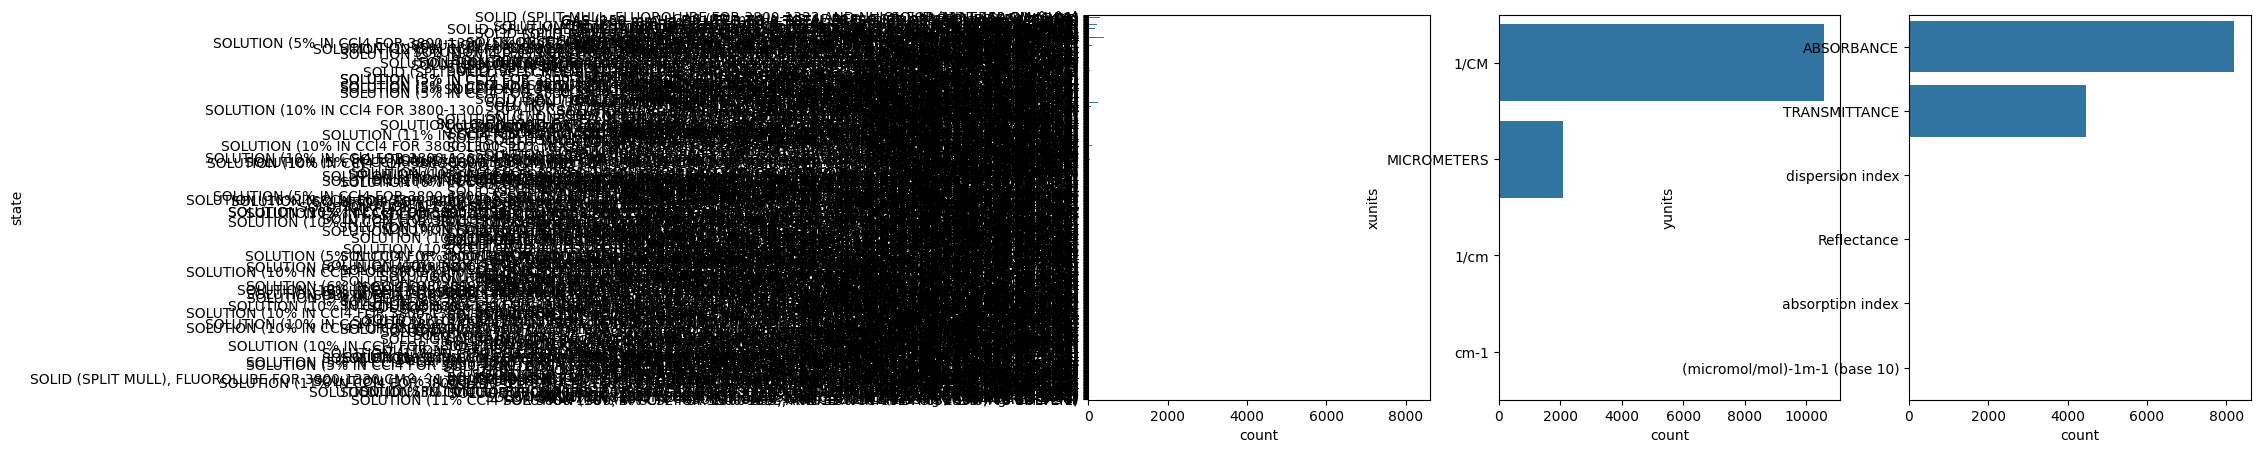

,deltax,firstx,lastx,firsty,maxx,minx,maxy,miny,npoints
count,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000
mean,3.241430,514.593865,3948.918534,2.936998,3948.918943,514.580762,0.413556,0.000229,1202.080087
std,0.996137,47.145245,63.044117,9.556963,63.044418,47.134182,0.479525,0.008056,468.026682
min,0.866873,192.941000,3741.130000,0.000000,3741.130000,192.941000,0.003000,0.000000,825.000000
25%,1.928980,450.000000,3846.000000,0.000782,3846.000000,450.000000,0.044438,0.000000,825.000000
50%,4.000000,549.800000,3966.000000,0.026031,3966.000000,549.759000,0.177607,0.000000,880.000000
75%,4.000000,550.000000,4000.700000,2.425000,4000.700000,550.000000,0.694340,0.000000,1790.000000
max,4.000000,605.050000,4020.520000,296.830000,4020.520000,605.050000,3.996980,0.544000,3980.000000


In [ ]:
# Validação e extração de propriedades dos espectros
properties_spectra_list = [
    'validation', 'title', 'molform', 'data type', 'state', 'xunits', 'yunits',
    'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints'
 ]

def data_validation(mol_dict):
    gas_rule = 'gas' in mol_dict.get('state', r'N\A').lower()
    wavelength_rule = 'cm' in mol_dict.get('xunits', r'N\A').lower()
    absorbance_rule = mol_dict.get('yunits', r'N\A').upper() in ['ABSORBANCE', 'TRANSMITTANCE']
    return all([gas_rule, wavelength_rule, absorbance_rule])

def extract_properties(cas_number, properties_spectra_list):
    mol_dict = JCAMP_reader(cas_number)
    properties = {}
    try:
        for key in properties_spectra_list:
            if key == 'validation':
                properties['validation'] = data_validation(mol_dict)
            elif key == 'state':
                properties[key] = str(mol_dict.get(key, '')).replace('$', '')
            else:
                properties[key] = mol_dict.get(key, None)
        return properties
    except Exception:
        return None

df_enrich[properties_spectra_list] = df_enrich['CAS'].apply(lambda x: pd.Series(extract_properties(x, properties_spectra_list)))
df_enrich.drop_duplicates(subset='CAS', inplace=True)

df_enrich.to_csv(f'{DATASET_PATH}/df_enrich_all.csv',index=False)

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df_enrich, y='state', ax=axes[0])
sns.countplot(data=df_enrich, y='xunits', ax=axes[1])
sns.countplot(data=df_enrich, y='yunits', ax=axes[2])
plt.tight_layout()
plt.show()

df_enrich = df_enrich[df_enrich.validation == True].reset_index(drop=True)
df_enrich[properties_spectra_list].describe()

In [16]:
# df_enrich_all['validation_yunits'].value_counts()

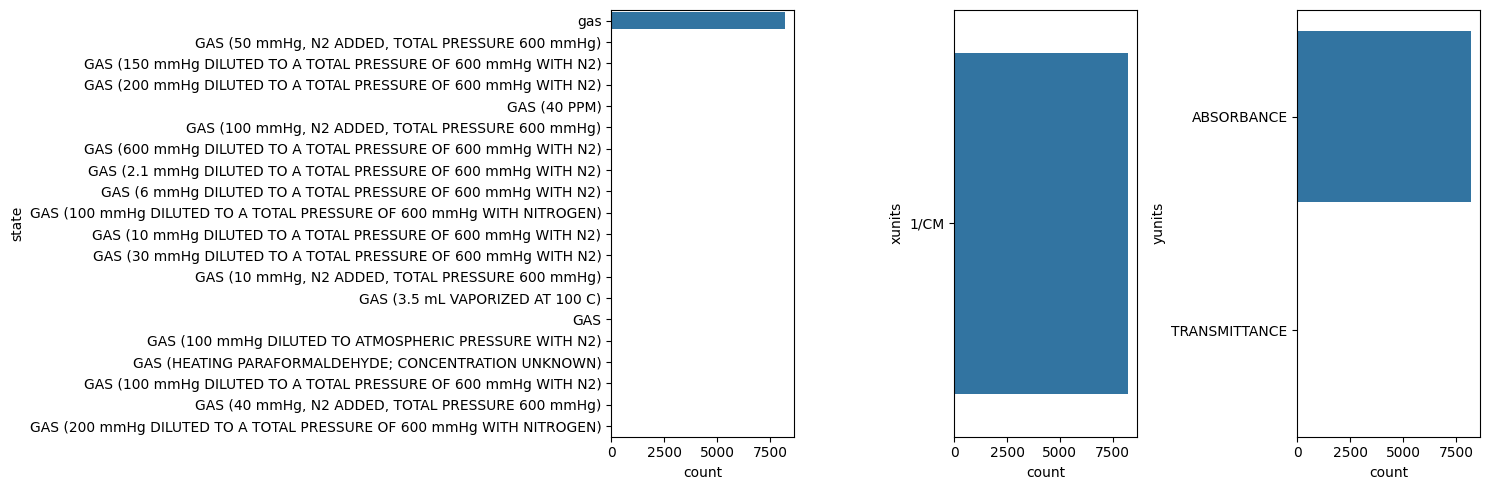

In [ ]:
# Visualização dos estados, xunits e yunits após validação
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data=df_enrich, y='state', ax=axes[0])
sns.countplot(data=df_enrich, y='xunits', ax=axes[1])
sns.countplot(data=df_enrich, y='yunits', ax=axes[2])
plt.tight_layout()
plt.show()

In [ ]:
df_enrich.to_csv(f'{DATASET_PATH}df_enrich.csv',index=False)

In [19]:
df_enrich

,CAS,inchi,y_target,alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,...,yunits,deltax,firstx,lastx,firsty,maxx,minx,maxy,miny,npoints
0,86-73-7,InChI=1S/C13H10/c1-3-7-12-10(5-1)9-11-6-2-4-8-...,"{'alkane': True, 'methyl': False, 'alkene': Fa...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ABSORBANCE,4.00000,450.0,3966.0,0.009789,3966.0,450.000,1.288090,0.0,880.0
1,84-66-2,InChI=1S/C12H14O4/c1-3-15-11(13)9-7-5-6-8-10(9...,"{'alkane': True, 'methyl': True, 'alkene': Fal...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,ABSORBANCE,4.00000,450.0,3966.0,0.004851,3966.0,450.000,0.898410,0.0,880.0
2,99-94-5,"InChI=1S/C8H8O2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,...","{'alkane': False, 'methyl': True, 'alkene': Fa...",0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,ABSORBANCE,4.00000,450.0,3966.0,0.108918,3966.0,450.000,1.356380,0.0,880.0
3,99-04-7,"InChI=1S/C8H8O2/c1-6-3-2-4-7(5-6)8(9)10/h2-5H,...","{'alkane': False, 'methyl': True, 'alkene': Fa...",0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,ABSORBANCE,4.00000,450.0,3966.0,0.008325,3966.0,450.000,1.935970,0.0,880.0
4,71-55-6,"InChI=1S/C2H3Cl3/c1-2(3,4)5/h1H3","{'alkane': True, 'methyl': True, 'alkene': Fal...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,ABSORBANCE,4.00000,450.0,3966.0,0.009789,3966.0,450.000,1.288090,0.0,880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,15872-41-0,InChI=1S/C12H16O3/c1-2-3-4-9-15-11-7-5-10(6-8-...,"{'alkane': True, 'methyl': True, 'alkene': Fal...",1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,ABSORBANCE,1.92898,549.8,4000.7,7.908900,4000.7,549.759,0.171939,0.0,1790.0
8237,354-76-7,"InChI=1S/C3H2F5NO/c4-2(5,1(9)10)3(6,7)8/h(H2,9...","{'alkane': True, 'methyl': False, 'alkene': Fa...",1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,ABSORBANCE,1.92898,549.8,4000.7,14.690000,4000.7,549.759,0.458760,0.0,1790.0
8238,2702-58-1,InChI=1S/C8H6N2O6/c1-16-8(11)5-2-6(9(12)13)4-7...,"{'alkane': False, 'methyl': True, 'alkene': Fa...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,ABSORBANCE,1.92898,549.8,4000.7,0.635450,4000.7,549.759,0.223919,0.0,1790.0
8239,622-25-3,InChI=1S/C8H7Cl/c9-7-6-8-4-2-1-3-5-8/h1-7H/b7-6+,"{'alkane': False, 'methyl': False, 'alkene': T...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,ABSORBANCE,1.92898,549.8,4000.7,1.330000,4000.7,549.759,0.028773,0.0,1790.0


In [20]:
df_enrich.CAS.value_counts()

,count
CAS,
366-18-7,1
23132-52-7,1
6929-08-4,1
98-52-2,1
24277-44-9,1
...,...
112-54-9,1
71-55-6,1
99-04-7,1
